In [63]:
import pandas as pd
import plotly.express as px
import numpy as np
import regex as re
import lightgbm as lgb
from sklearn.model_selection import train_test_split, cross_validate, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet
from sklearn.dummy import DummyRegressor

In [64]:
# Setting a random seed for reproducibility
nb_rseed = 123

# PUMS KWH Consumption Modeling
Objective: use fields in the following PUMS dataset to predict KWH consumption for a given housing unit.
https://www.eia.gov/consumption/residential/data/2009/index.php?view=microdata

In [65]:
# Reading in the dataset for initial cleaning
raw_ds = pd.read_csv('https://www.eia.gov/consumption/residential/data/2009/csv/recs2009_public.csv')

C:\Users\jacob\miniconda3\envs\neurotrack\lib\site-packages\IPython\core\interactiveshell.py:3441: DtypeWarning:

Columns (717,718) have mixed types.Specify dtype option on import or set low_memory=False.



Let's check that error out. None of the fields should be mixed as far as I can tell.

In [66]:
raw_ds.iloc[:,[717,718]]

,NOCRCASH,NKRGALNC
0,-2,-2
1,-2,-2
2,-2,-2
3,-2,-2
4,-2,-2
...,...,...
12078,-2,-2
12079,-2,-2
12080,-2,-2
12081,-2,-2


In [67]:
raw_ds["NOCRCASH"].unique()

array([-2, 1, 6, 15, 4, '-2', '1', '20', '.', '12', '4', '10', '3', '24',
       '55', '6', 8, 28, 5, 55, 3, 16, 2, 20, 10, 24, 40, 12, 25],
      dtype=object)

In [68]:
raw_ds["NKRGALNC"].unique()

array([-2, 1, 5, 10, '-2', '10', '15', '1', '8', '.', '5', '3', '2', '77',
       30, 3, 15, 8, 55, 2, 20], dtype=object)

These both are continuous columns that shouldn't have a '.' so for now I'll impute with a value of 0

In [69]:
cols_with_dot = ["NOCRCASH", "NKRGALNC"]

In [70]:
raw_ds[cols_with_dot] = np.select([raw_ds[cols_with_dot] == '.'],
                                                  [0], default = raw_ds[cols_with_dot])

In [71]:
raw_ds[cols_with_dot] = raw_ds[cols_with_dot].astype('int')

## Loading in data dict to get list of numeric, ordinal, and categorical features

For an intial first pass, it seems reasonable to remove all the fields starting with 'z' since these are imputation flags and we wouldn't want to include them in feature selection. We'll just stick to the features in these lists going forward.

Additionally, I am making the assumption that we should disregard all other KPH, dollar electricity, and BTUs of electricity fields as predictors (i.e KPH used for cooling etc) since a user of the model would be unlikely to have access to that information and not total KPH as well and BTU and dollar electricity are likely near perfect predictors. Furthermore the total KPH is the sum of all the other KPH fields- so using the other KPH fields would make for a very accurate but rather trivial model. 

In [72]:
data_dict = pd.read_excel('rec2009_neurotrack_challenge.xlsx')

In [73]:
data_dict = data_dict[data_dict.Type.notnull()]

In [74]:
data_dict_inst = data_dict[data_dict.Instructions.notnull()]

In [75]:
numeric_features = data_dict[data_dict['Type'].str.contains('num')]['Variable Name'].values.tolist()

In [76]:
ordinal_features = data_dict[data_dict['Type'].str.contains('ord')]['Variable Name'].values.tolist()

In [77]:
categorical_features = data_dict[data_dict['Type'].str.contains('cat')]['Variable Name'].values.tolist()

## Cleaning based on labels in "instructions" column

Doing this again I would approach the data cleaning differently and would have made the notes I made more machine readable but this works. Mostly, this is switching around numbers so that ordinal scales make sense for our problem or NAs to be 0 where it made sense in the data. Check in with the data dictionary for more info on why and when things are the way there are.

In [78]:
def follow_instructions(inst_str, val_to_replace, val):
    """Replaces values in raw_ds where inst_str matches the instructions column"""
    feats = data_dict_inst[data_dict_inst['Instructions'].str.contains(inst_str)]['Variable Name'].values.tolist()
    raw_ds[feats] = np.select([raw_ds[feats] == val_to_replace],
                                                  [val], default = raw_ds[feats])

In [79]:
follow_instructions('neg 2 should be 0', -2, 0)
follow_instructions('neg 2 should be 65', -2, 65)
follow_instructions('41 should be 4.1 and 42 should be 4.2', 41, 4.1)
follow_instructions('41 should be 4.1 and 42 should be 4.2', 42, 4.2)
follow_instructions('neg 2 and 50 should be 0', -2, 0)
follow_instructions('neg 2 and 50 should be 0', 50, 0)
follow_instructions('4 and 2 should be 0', 4, 0)
follow_instructions('4 and 2 should be 0', 2, 0)
follow_instructions('0 and -2 should be 7', 0, 7)
follow_instructions('0 and -2 should be 7', -2, 7)
follow_instructions('neg 2 should be 5', -2, 5)
follow_instructions('0 should be 7', 0, 7)
follow_instructions('neg should be 0', -2, 0)
follow_instructions('neg 2 and 0 should be 5 and 6', -2, 5)
follow_instructions('neg 2 and 0 should be 5 and 6', 0, 6)
follow_instructions('neg 2 should be 4', -2, 4)

## Spot check of imported data

In [80]:
# A spot check to see that all of the columns have come in
raw_ds.describe()

,DOEID,REGIONC,DIVISION,REPORTABLE_DOMAIN,TYPEHUQ,NWEIGHT,HDD65,CDD65,HDD30YR,CDD30YR,...,PERIODKR,SCALEKER,HDD50,CDD80,GND_HDD65,WSF,OA_LAT,GWT,DesignDBT99,DesignDBT1
count,12083.000000,12083.000000,12083.000000,12083.000000,12083.000000,12083.000000,12083.000000,12083.000000,12083.000000,12083.000000,...,12083.000000,12083.000000,12083.000000,12083.000000,12083.000000,12083.000000,12083.000000,12083.000000,12083.000000,12083.000000
mean,6042.000000,2.628321,5.373086,14.783663,2.659604,9402.981870,4141.375238,1415.406108,4135.146983,1443.503104,...,-1.935943,-1.955392,1681.961764,139.568485,3763.728544,0.499036,5.656046,59.128693,20.256311,90.359431
std,3488.205986,1.042142,2.859366,8.195824,1.192627,5192.101419,2317.759375,1134.659475,2260.543686,1021.748722,...,0.589907,0.415810,1401.079218,264.186908,2597.754419,0.083520,6.797205,8.678293,15.337626,6.166669
min,1.000000,1.000000,1.000000,1.000000,1.000000,476.100000,0.000000,0.000000,0.000000,0.000000,...,-2.000000,-2.000000,0.000000,0.000000,0.000000,0.310000,0.000000,36.000000,-23.000000,60.000000
25%,3021.500000,2.000000,3.000000,8.000000,2.000000,6297.040000,2197.500000,561.000000,2224.000000,712.000000,...,-2.000000,-2.000000,262.500000,4.000000,1246.500000,0.430000,1.000000,52.000000,9.000000,87.000000
50%,6042.000000,3.000000,5.000000,15.000000,2.000000,7970.630000,4483.000000,1045.000000,4502.000000,1179.000000,...,-2.000000,-2.000000,1684.000000,30.000000,3878.000000,0.500000,3.000000,58.000000,18.000000,90.000000
75%,9062.500000,3.000000,7.000000,21.000000,3.000000,11330.030000,5913.000000,1897.000000,5854.000000,1842.500000,...,-2.000000,-2.000000,2662.000000,117.000000,5834.000000,0.560000,7.000000,66.000000,33.000000,94.000000
max,12083.000000,4.000000,10.000000,27.000000,5.000000,95779.140000,12525.000000,5480.000000,13346.000000,5357.000000,...,5.000000,3.000000,7623.000000,1884.000000,11567.000000,0.800000,34.000000,89.000000,67.000000,118.000000


## EDA

Checking out our target we can see it's fairly normal with some large outliers and a bit of a right hand skew. Given more time an investigation into whether such 150kwh is at all possible would be warranted to determine if the extreme outlier should be removed or a different loss function less sensitive to outliers should be used.

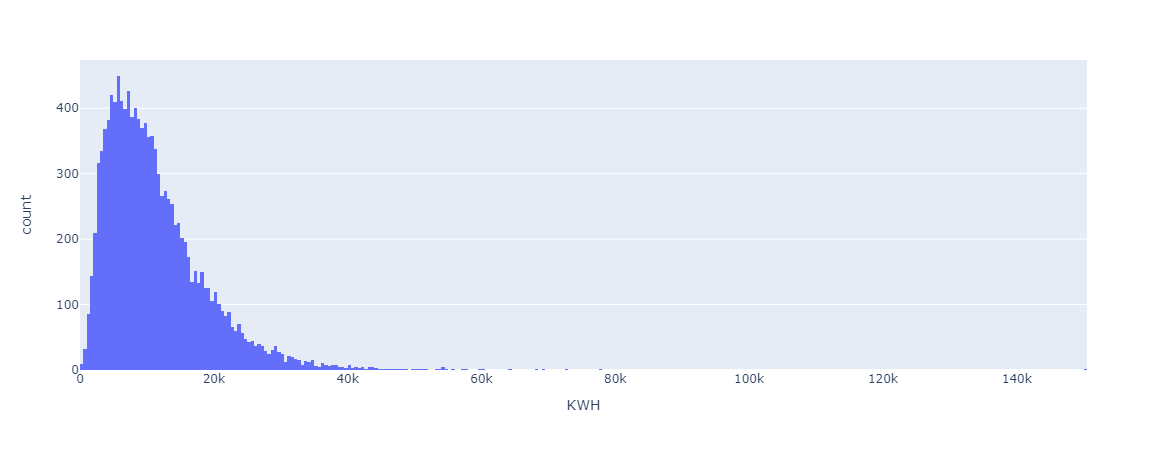

In [81]:
fig = px.histogram(raw_ds, x="KWH")
fig.show()

In [82]:
raw_ds.isnull().sum().sum()

0

No missing data! Yay! On a longer term project I would also spend some time here looking for interactions that might be useful on the feature engineering side as well as checking for outliers in some of the other fields.

## Train Test Split

In [83]:
X = raw_ds.drop(columns = ['KWH'])
y = raw_ds['KWH']

In [84]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = nb_rseed)

## Preprocessing and First Pass Models

Creating our base pipelines for transformation. One hot encoding our categorical variables and transforming ordinals to integers. 

In [85]:
def get_preprocessor(numeric_features, ordinal_features, categorical_features):
    ord_enc = OrdinalEncoder(handle_unknown ='use_encoded_value', unknown_value = 42)
    numeric_transformer = Pipeline(
        steps=[("scaler", StandardScaler())]
    )
    categorical_transformer = Pipeline(
        steps=[
            ("onehot", OneHotEncoder(handle_unknown="ignore")),
        ]
    )
    ordinal_transformer = Pipeline(
        steps=[
            ("ordinal", ord_enc),
        ]
    )
    full_preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, numeric_features),
            ("ord", ordinal_transformer, ordinal_features),
            ("cat", categorical_transformer, categorical_features)
        ], 
    )
    return full_preprocessor

In [86]:
transformed_features = get_preprocessor(numeric_features, ordinal_features, categorical_features).fit_transform(X_train) 
transformed_features.shape

(9666, 1412)

Given the dimensionality of the problem, I'll start out with a baseline, gradient boosted tree, and a ridge regression so that we have options for regularization. Typically I'd try 1-2 more models in this step if this was a longer term project.

In [87]:
# Creating a baseline
dummy_full = Pipeline(
    steps=[
        ("preprocessor", get_preprocessor(numeric_features, ordinal_features, categorical_features)),
        ("reg", DummyRegressor(strategy = 'median'))
    ]
)

In [88]:
# L2 regularization pipeline
lr_pipe_full = Pipeline(
    steps=[
        ("preprocessor", get_preprocessor(numeric_features, ordinal_features, categorical_features)),
        ("reg", Ridge())
    ]
)

In [89]:
# Light gradient boosted tree pipeline
gbm_pipe_full = Pipeline(
    steps=[
        ("preprocessor", get_preprocessor(numeric_features, ordinal_features, categorical_features)),
        ("reg", lgb.LGBMRegressor())
    ]
)

Running 5-fold cross validation for each model

In [90]:
x = pd.DataFrame(cross_validate(dummy_full, X_train, y_train, n_jobs = -1, return_train_score = True)).describe()
x['label'] = 'dummy'
x = x.reset_index().iloc[1,:]

In [91]:
y = pd.DataFrame(cross_validate(lr_pipe_full, X_train, y_train, n_jobs = -1, return_train_score = True)).describe()
y['label'] = 'l2 Regression'
y = y.reset_index().iloc[1,:]

In [92]:
gbm = pd.DataFrame(cross_validate(gbm_pipe_full, X_train, y_train, n_jobs = -1, return_train_score = True)).describe()
gbm['label'] = 'gbm'
gbm = gbm.reset_index().iloc[1,:]

In [93]:
results = pd.concat([x,y, gbm], axis = 1)
results.columns = ['dummy', 'l2 Regression', 'GBM']
results = results.drop(labels=['label', 'index'])
results

,dummy,l2 Regression,GBM
fit_time,1.427609,3.012672,4.315241
score_time,0.351629,0.290016,0.341829
test_score,-0.047683,0.612328,0.655164
train_score,-0.047232,0.722881,0.873153


Checking cross validation results, we're getting what seems to be a reasonable $R^2$ and a clear improvement over our baseline models. Let's see if we can't improve things with some better features and a bit of hyperparameter tuning.

## Feature Engineering

Given that HVAC systems (heating and cooling) tend to be the greatest electricity expenditures for homes, I'll start my engineering features based on the feature HVAC related features identified as important by the LGBM since that's looking like the top model at the moment. The RECS website also mentions that they model the proprortion of heating and cooling electricity expenditures based on some non-linear modeling of their own, which would be an interesting area to explore feature engineering wise in the future.

In [94]:
gbm = gbm_pipe_full.fit(X_train, y_train)

In [95]:
feats = numeric_features + ordinal_features + gbm[0].transformers_[2][1][0].get_feature_names().tolist()

In [96]:
feat_imports = pd.DataFrame({ "feat_labels" : feats, "feat_imports" : gbm[1].feature_importances_})

In [97]:
feat_imports.sort_values(by = "feat_imports", ascending = False).iloc[:20]

,feat_labels,feat_imports
54,TOTCSQFT,68
4,YEARMADE,50
771,x152_5,47
57,CDD80,43
3,CDD30YR,42
49,HHAGE,40
141,AGEHHMEMCAT2,40
52,TOTHSQFT,38
37,LGT12,36
142,AGEHHMEMCAT3,34


Let's start with some of the top performing features and create interactions with the indicator for whether fuel is used for heating as well as other reasonable interactions.

In [98]:
# Multiplying yearmade and fuel heat together if electricity is used, else 5
X_train["FUELHEATxYEARMADE"] = np.where(X_train["FUELHEAT"] == 5, X_train["FUELHEAT"] * X_train["YEARMADE"], 0) 
# Multiplying total heated by sqft by 5 if electricity is used, else 0
X_train["FUELHEATxTOTHSQFT"] = np.where(X_train["FUELHEAT"] == 5, X_train["FUELHEAT"] * X_train["TOTHSQFT"], 0) 
# Multiplying totaly cooling days by total cooled sqft
X_train["CDD80xTOTCSQFT"] = X_train["CDD80"] * X_train["TOTCSQFT"]
X_train["CDD30YRxTOTCSQFT"] = X_train["CDD30YR"] * X_train["TOTCSQFT"]
X_train["ACROOMSxTOTCSQFT"] = X_train["ACROOMS"] * X_train["TOTCSQFT"]

C:\Users\jacob\AppData\Local\Temp/ipykernel_15644/3637963943.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\jacob\AppData\Local\Temp/ipykernel_15644/3637963943.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\jacob\AppData\Local\Temp/ipykernel_15644/3637963943.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/panda

Adding in our new features.

In [99]:
engineered_num_feats = ["FUELHEATxTOTHSQFT", "CDD80xTOTCSQFT", "CDD30YRxTOTCSQFT", "FUELHEATxYEARMADE", "ACROOMSxTOTCSQFT"]

In [100]:
numeric_features = engineered_num_feats + numeric_features

Determining if we have any increased performance based on our new features.

In [101]:
lr_pipe_full = Pipeline(
    steps=[
        ("preprocessor", get_preprocessor(numeric_features, ordinal_features, categorical_features)),
        ("reg", Ridge())
    ]
)

In [102]:
gbm_pipe_full = Pipeline(
    steps=[
        ("preprocessor", get_preprocessor(numeric_features, ordinal_features, categorical_features)),
        ("reg", lgb.LGBMRegressor())
    ]
)

In [103]:
y = pd.DataFrame(cross_validate(lr_pipe_full, X_train, y_train, n_jobs = -1, return_train_score = True)).describe()
y['label'] = 'l2 Regression'
y = y.reset_index().iloc[1,:]

In [104]:
gbm = pd.DataFrame(cross_validate(gbm_pipe_full, X_train, y_train, n_jobs = -1, return_train_score = True)).describe()
gbm['label'] = 'gbm'
gbm = gbm.reset_index().iloc[1,:]

In [105]:
f_results = pd.concat([y, gbm], axis = 1)
f_results.columns = [ 'l2 Regression engineered', 'GBM engineered']
f_results.drop(labels=['label', 'index'])

,l2 Regression engineered,GBM engineered
fit_time,3.075689,4.366362
score_time,0.388299,0.321509
test_score,0.616114,0.654959
train_score,0.73179,0.873649


In [106]:
f_results = pd.concat([y, gbm], axis = 1)
f_results.columns = [ 'l2 Regression engineered', 'GBM engineered']
f_results = f_results.drop(labels=['label', 'index'])

pd.concat([f_results, results], axis = 1)

,l2 Regression engineered,GBM engineered,dummy,l2 Regression,GBM
fit_time,3.075689,4.366362,1.427609,3.012672,4.315241
score_time,0.388299,0.321509,0.351629,0.290016,0.341829
test_score,0.616114,0.654959,-0.047683,0.612328,0.655164
train_score,0.73179,0.873649,-0.047232,0.722881,0.873153


In [107]:
gbm = gbm_pipe_full.fit(X_train, y_train)
feats = numeric_features + ordinal_features + gbm[0].transformers_[2][1][0].get_feature_names().tolist()
feat_imports = pd.DataFrame({ "feat_labels" : feats, "feat_imports" : gbm[1].feature_importances_})
feat_imports.sort_values(by = "feat_imports", ascending = False).iloc[:20]

,feat_labels,feat_imports
0,FUELHEATxTOTHSQFT,104
2,CDD30YRxTOTCSQFT,60
9,YEARMADE,40
4,ACROOMSxTOTCSQFT,40
59,TOTCSQFT,40
58,TOTUSQFT,39
54,HHAGE,37
55,TOTSQFT,34
57,TOTHSQFT,34
70,OCCUPYYRANGE,32


These features don't seem to be making a major difference in $R^2$ but the fact that they're all in the top 20 for feature importance is a good sign. Given more time to work on the problem, this is probably where I would invest the bulk of my effort to try to improve performance on the problem.

## Hyperparameter Tuning

Next let's see what we can do as far as optimizing the amount of regularization and the learning rate in our simple regression and our LGBM candidate models. 

In [108]:
pre = get_preprocessor(numeric_features, ordinal_features, categorical_features)

In [109]:
distributions = dict(alpha=np.linspace(start = 1, stop = 10))
clf = RandomizedSearchCV(Ridge(), distributions, random_state=0)
search = clf.fit(pre.fit_transform(X_train), y_train)
search.best_params_

{'alpha': 8.53061224489796}

In [110]:
distributions = dict(reg_alpha=np.linspace(start = 1, stop = 10),
                     reg_lambda=np.linspace(start = 1, stop = 10),
                     learning_rate=np.linspace(start = .01, stop = 1)
                    )
clf = RandomizedSearchCV(lgb.LGBMRegressor(), distributions, random_state=0)
search = clf.fit(pre.fit_transform(X_train), y_train)
search.best_params_

{'reg_lambda': 8.89795918367347,
 'reg_alpha': 5.408163265306123,
 'learning_rate': 0.1716326530612245}

In [111]:
gbm_pipe_full = Pipeline(
    steps=[
        ("preprocessor", get_preprocessor(numeric_features, ordinal_features, categorical_features)),
        ("reg", lgb.LGBMRegressor(reg_lambda= 8.89795918367347,
                                  reg_alpha = 5.408163265306123,
                                  learning_rate = 0.1716326530612245))
    ]
)

In [112]:
lr_pipe_full = Pipeline(
    steps=[
        ("preprocessor", get_preprocessor(numeric_features, ordinal_features, categorical_features)),
        ("reg", Ridge(alpha = 8.53))
    ]
)

In [113]:
y = pd.DataFrame(cross_validate(lr_pipe_full, X_train, y_train, n_jobs = -1, return_train_score = True)).describe()
y['label'] = 'l2 Regression eng tuned'
y = y.reset_index().iloc[1,:]

In [114]:
gbm = pd.DataFrame(cross_validate(gbm_pipe_full, X_train, y_train, n_jobs = -1, return_train_score = True)).describe()
gbm['label'] = 'gbm regression eng tuned'
gbm = gbm.reset_index().iloc[1,:]

In [115]:
ft_results = pd.concat([y, gbm], axis = 1)
ft_results.columns = [ 'l2 Regression engineered', 'GBM engineered']
ft_results.drop(labels=['label', 'index'])

,l2 Regression engineered,GBM engineered
fit_time,2.099081,4.170648
score_time,0.259031,0.306271
test_score,0.63618,0.647071
train_score,0.72684,0.902596


Interestingly, it seems like our Ridge regression has benefited more from the hyperparameter tuning compared to the LGBM model! However, the LGBM model still looks like it's doing the best, so I'll go ahead and select it to use as our final model against the test set.

In [116]:
# Runnining on the test set

In [117]:
# Multiplying yearmade and fuel heat together if electricity is used, else 5
X_test["FUELHEATxYEARMADE"] = np.where(X_test["FUELHEAT"] == 5, X_test["FUELHEAT"] * X_test["YEARMADE"], 0) 
# Multiplying total heated by sqft by 5 if electricity is used, else 0
X_test["FUELHEATxTOTHSQFT"] = np.where(X_test["FUELHEAT"] == 5, X_test["FUELHEAT"] * X_test["TOTHSQFT"], 0) 
# Multiplying totaly cooling days by total cooled sqft
X_test["CDD80xTOTCSQFT"] = X_test["CDD80"] * X_test["TOTCSQFT"]
X_test["CDD30YRxTOTCSQFT"] = X_test["CDD30YR"] * X_test["TOTCSQFT"]
X_test["ACROOMSxTOTCSQFT"] = X_test["ACROOMS"] * X_test["TOTCSQFT"]

C:\Users\jacob\AppData\Local\Temp/ipykernel_15644/3776960617.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\jacob\AppData\Local\Temp/ipykernel_15644/3776960617.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\jacob\AppData\Local\Temp/ipykernel_15644/3776960617.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/panda

In [118]:
gbm_pipe = gbm_pipe_full.fit(X_train, y_train)
gbm_pipe.score(X_test, y_test)

0.6626540258262736

All in all, the model seems to produce reasonable results. Further EDA and feature engineering as well as exploring other models would be additional options to increase performance going forward.